# Data collection using the YouTube API

In [2]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns

## Collection of channel_ids and stats of YouTube channels that review Big Brother

In [5]:
api_key='xx3'

channel_ids=['UCaAyMt4ipyze9GHqbhhZTtw', #FSWG
             'UCBC6ubZ79yjWxW7JDr6U0qg',  #S&Mabs
             'UCSQciULLxvjeYDed4bRRYQw',  #OD
             'UC33UGctOsStEOQ2mYXAWYBQ'   #Fwl
            ]

youtube=build('youtube','v3',developerKey=api_key)

In [6]:
# I want to collect channel stats where we get the channel name, subscribers, views, total videos in each playlist, and playlist ID

def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    return all_data

In [7]:
channel_statistics = get_channel_stats(youtube, channel_ids)

In [8]:
channel_data = pd.DataFrame(channel_statistics)

In [9]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Funpop With Lilian,22100,5662732,1156,UU33UGctOsStEOQ2mYXAWYBQ
1,Olufemi Daniel,179000,25398426,816,UUSQciULLxvjeYDed4bRRYQw
2,Shark & Marine TV,67600,6224043,727,UUBC6ubZ79yjWxW7JDr6U0qg
3,Frankly Speaking with Glory Elijah,359000,119621385,3103,UUaAyMt4ipyze9GHqbhhZTtw


In [10]:
# data cleaning to get a visualisation on channel comparisons

channel_data['subscribers'] = pd.to_numeric(channel_data['subscribers'])
channel_data['views'] = pd.to_numeric(channel_data['views'])
channel_data['totalVideos'] = pd.to_numeric(channel_data['totalVideos'])
channel_data.dtypes

channelName    object
subscribers     int64
views           int64
totalVideos     int64
playlistId     object
dtype: object

## Channel performance by views and subscribers

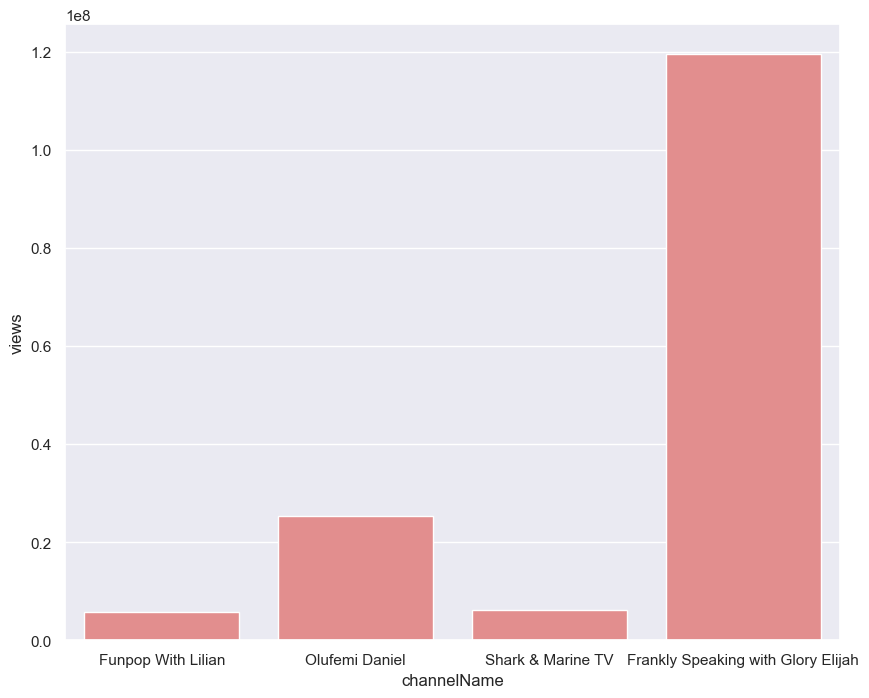

In [11]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='views', data=channel_data, color='lightcoral')

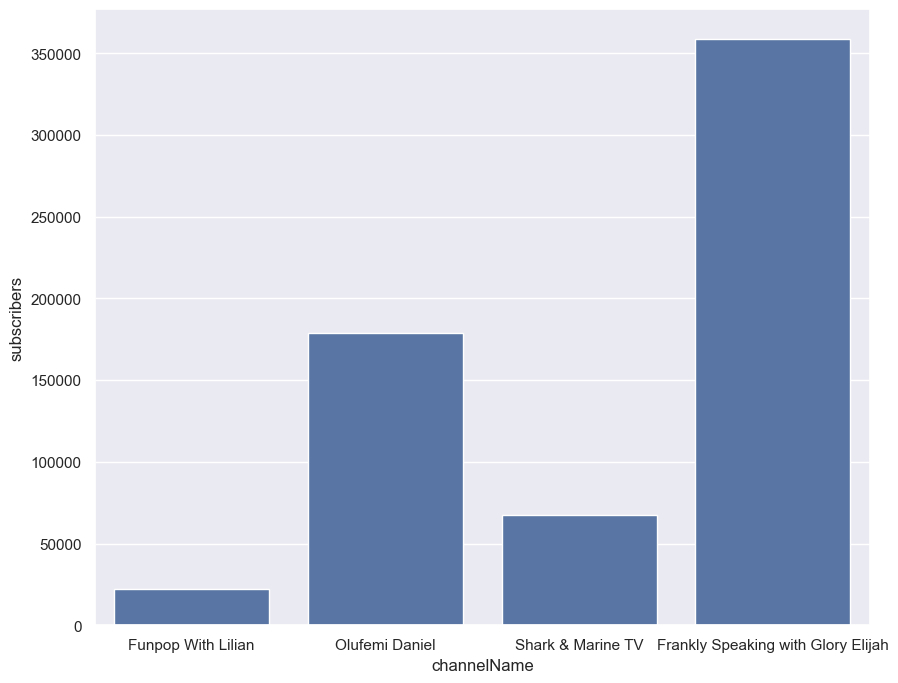

In [12]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data)

### Analysis:
According to the two barplots above we see that Frankly Speaking with Glory Elijah (FSWG) performs best with the highest number of views and subscribers followed by Olufemi Daniel. Due to the great difference in numbers between channels we will do an analysis only on FSWG.

## Statistic data collection for FSWG channel

In [13]:
playlist_id = channel_data.loc[channel_data['channelName'] == 'Frankly Speaking with Glory Elijah', 'playlistId'].iloc[0]

In [14]:
playlist_id

'UUaAyMt4ipyze9GHqbhhZTtw'

In [17]:
# Get total video uploads in playlist_id= 'UUaAyMt4ipyze9GHqbhhZTtw'. Note that there is only one playlist on the FSWG YouTube channel.

def get_video_id(youtube, playlist_id):
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [18]:
video_ids = get_video_id(youtube, playlist_id)

In [13]:
len(video_ids)

3102

In [19]:
# Get video details of every upload in the playlist, such as the video title, date of upload, number of views, likes, comments, and the duration 
# of each video

def get_video_details(youtube, video_ids):
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount'],
                             'contentDetails': ['duration']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)


In [20]:
video_details = get_video_details(youtube, video_ids)

In [21]:
video_details

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration
0,CL_r-Ca0-Ps,Frankly Speaking with Glory Elijah,GAME OF THRONES: Analyzing the TOP VILLAINS an...,2025-10-26T04:15:39Z,3410,232,15,PT1H43M3S
1,bfVmtxg2CUc,Frankly Speaking with Glory Elijah,BBNaija Season 10 Live: THE HATE CULTURE IN TH...,2025-10-18T18:45:33Z,33435,1749,190,PT4H19M58S
2,vl9kcNH_3bU,Frankly Speaking with Glory Elijah,BBNaija Season 10 Live: GENDER BIAS IN GBV: TH...,2025-10-11T20:49:01Z,50064,3297,279,PT6H17M35S
3,08WJdty9BfQ,Frankly Speaking with Glory Elijah,THE 15 GAMERS OF THE BBNAIJA 10/10 SEASON (BRI...,2025-10-08T05:00:00Z,39664,2876,843,PT57M2S
4,RANG-d0wKcg,Frankly Speaking with Glory Elijah,"GLORY ELIJAH REVEALS HER FAVE, IS IT IMISI, DE...",2025-10-07T05:00:34Z,64057,4179,1309,PT45M44S
...,...,...,...,...,...,...,...,...
3099,ynFsReCIifE,Frankly Speaking with Glory Elijah,What you Never Knew About Chokers (EP4),2017-05-20T08:31:08Z,1021,22,1,PT6M24S
3100,leQNqq-jNgk,Frankly Speaking with Glory Elijah,Pissed! Covenant University and 200 Suspended ...,2017-05-13T13:54:29Z,630,27,4,PT5M8S
3101,DiOse_Gt-vc,Frankly Speaking with Glory Elijah,"Why I do not like 'The Wedding Party Movie"" (EP2)",2017-05-04T08:46:28Z,691,43,10,PT9M15S
3102,4CHIaUYFkLI,Frankly Speaking with Glory Elijah,What TBoss Said in the BBNaija 2017 Show (EP1),2017-04-27T07:01:33Z,1136,64,7,PT8M18S


## Data cleaning and manipulation

In this process we will be accomplishing the following:
- Correcting data types
- Change duration from its current view to a numeric column that converts hours to seconds
- Extract month and day name from the date column 'publishedAt'
- Create a name_check column that categorises Big Brother seasons, and the rest will be categorised as 'other'

In [22]:
video_details.dtypes

video_id        object
channelTitle    object
title           object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
dtype: object

In [28]:
#change data types

video_details['publishedAt'] = pd.to_datetime(video_details['publishedAt']).dt.date
video_details['viewCount'] = pd.to_numeric(video_details['viewCount'])
video_details['likeCount'] = pd.to_numeric(video_details['likeCount'])
video_details['commentCount'] = pd.to_numeric(video_details['commentCount'])
# video_details

In [30]:
import isodate

In [31]:
video_details['durationSecs'] = video_details['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

In [32]:
video_details['Month'] = pd.to_datetime(video_details['publishedAt']).dt.strftime('%B')
video_details['Day_name'] = pd.to_datetime(video_details['publishedAt']).dt.strftime('%A')

In [33]:
video_details

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,durationSecs,Month,Day_name
0,CL_r-Ca0-Ps,Frankly Speaking with Glory Elijah,GAME OF THRONES: Analyzing the TOP VILLAINS an...,2025-10-26,3410,232.0,15,PT1H43M3S,6183.0,October,Sunday
1,bfVmtxg2CUc,Frankly Speaking with Glory Elijah,BBNaija Season 10 Live: THE HATE CULTURE IN TH...,2025-10-18,33435,1749.0,190,PT4H19M58S,15598.0,October,Saturday
2,vl9kcNH_3bU,Frankly Speaking with Glory Elijah,BBNaija Season 10 Live: GENDER BIAS IN GBV: TH...,2025-10-11,50064,3297.0,279,PT6H17M35S,22655.0,October,Saturday
3,08WJdty9BfQ,Frankly Speaking with Glory Elijah,THE 15 GAMERS OF THE BBNAIJA 10/10 SEASON (BRI...,2025-10-08,39664,2876.0,843,PT57M2S,3422.0,October,Wednesday
4,RANG-d0wKcg,Frankly Speaking with Glory Elijah,"GLORY ELIJAH REVEALS HER FAVE, IS IT IMISI, DE...",2025-10-07,64057,4179.0,1309,PT45M44S,2744.0,October,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
3099,ynFsReCIifE,Frankly Speaking with Glory Elijah,What you Never Knew About Chokers (EP4),2017-05-20,1021,22.0,1,PT6M24S,384.0,May,Saturday
3100,leQNqq-jNgk,Frankly Speaking with Glory Elijah,Pissed! Covenant University and 200 Suspended ...,2017-05-13,630,27.0,4,PT5M8S,308.0,May,Saturday
3101,DiOse_Gt-vc,Frankly Speaking with Glory Elijah,"Why I do not like 'The Wedding Party Movie"" (EP2)",2017-05-04,691,43.0,10,PT9M15S,555.0,May,Thursday
3102,4CHIaUYFkLI,Frankly Speaking with Glory Elijah,What TBoss Said in the BBNaija 2017 Show (EP1),2017-04-27,1136,64.0,7,PT8M18S,498.0,April,Thursday


In [35]:
def check_for_names(title):
    if pd.isna(title):
        return "Missing"
    elif pd.Series(title).str.contains('REUNION', case=False, regex=True).iloc[0]:
        return "Reunion"
    elif pd.Series(title).str.contains('BBNAIJA 2019', case=False, regex=True).iloc[0]:
        return "BBN Season 4"
    elif pd.Series(title).str.contains('BBNAIJA 2020|BIG BROTHER NAIJA 2020', case=False, regex=True).iloc[0]:
        return "BBN Season 5"
    elif pd.Series(title).str.contains('BBNAIJA 2021', case=False, regex=True).iloc[0]:
        return "BBN Season 6"
    elif pd.Series(title).str.contains('BBMZANSI 2022', case=False, regex=True).iloc[0]:
        return "BBM Season 3"
    elif pd.Series(title).str.contains('BBNAIJA 2022|BBNAIJA  2022|BBBAIJA 2022', case=False, regex=True).iloc[0]:
        return "BBN Season 7"
    elif pd.Series(title).str.contains('BIG BROTHER TITANS', case=False, regex=True).iloc[0]:
        return "BBTitans"
    elif pd.Series(title).str.contains('BIG BROTHER: ALL STARS|BBNAIJA ALL STARS', case=False, regex=True).iloc[0]:
        return "BBN Season 8"
    elif pd.Series(title).str.contains('BBMZANSI SEASON 4', case=False, regex=True).iloc[0]:
        return "BBM Season 4"
    elif pd.Series(title).str.contains('NO LOOSE GUARD', case=False, regex=True).iloc[0]:
        return "BBN Season 9"
    elif pd.Series(title).str.contains('BBMZANSI SEASON 5', case=False, regex=True).iloc[0]:
        return "BBM Season 5"
    elif pd.Series(title).str.contains('BBNAIJA 10/10|BBNAIJA 10 /10', case=False, regex=True).iloc[0]:
        return "BBN Season 10"
    else:
        return "Other"

# Apply the function to the DataFrame
video_details['name_check'] = video_details['title'].apply(check_for_names)

In [36]:
video_details

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,durationSecs,Month,Day_name,name_check
0,CL_r-Ca0-Ps,Frankly Speaking with Glory Elijah,GAME OF THRONES: Analyzing the TOP VILLAINS an...,2025-10-26,3410,232.0,15,PT1H43M3S,6183.0,October,Sunday,Other
1,bfVmtxg2CUc,Frankly Speaking with Glory Elijah,BBNaija Season 10 Live: THE HATE CULTURE IN TH...,2025-10-18,33435,1749.0,190,PT4H19M58S,15598.0,October,Saturday,Other
2,vl9kcNH_3bU,Frankly Speaking with Glory Elijah,BBNaija Season 10 Live: GENDER BIAS IN GBV: TH...,2025-10-11,50064,3297.0,279,PT6H17M35S,22655.0,October,Saturday,Other
3,08WJdty9BfQ,Frankly Speaking with Glory Elijah,THE 15 GAMERS OF THE BBNAIJA 10/10 SEASON (BRI...,2025-10-08,39664,2876.0,843,PT57M2S,3422.0,October,Wednesday,BBN Season 10
4,RANG-d0wKcg,Frankly Speaking with Glory Elijah,"GLORY ELIJAH REVEALS HER FAVE, IS IT IMISI, DE...",2025-10-07,64057,4179.0,1309,PT45M44S,2744.0,October,Tuesday,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
3099,ynFsReCIifE,Frankly Speaking with Glory Elijah,What you Never Knew About Chokers (EP4),2017-05-20,1021,22.0,1,PT6M24S,384.0,May,Saturday,Other
3100,leQNqq-jNgk,Frankly Speaking with Glory Elijah,Pissed! Covenant University and 200 Suspended ...,2017-05-13,630,27.0,4,PT5M8S,308.0,May,Saturday,Other
3101,DiOse_Gt-vc,Frankly Speaking with Glory Elijah,"Why I do not like 'The Wedding Party Movie"" (EP2)",2017-05-04,691,43.0,10,PT9M15S,555.0,May,Thursday,Other
3102,4CHIaUYFkLI,Frankly Speaking with Glory Elijah,What TBoss Said in the BBNaija 2017 Show (EP1),2017-04-27,1136,64.0,7,PT8M18S,498.0,April,Thursday,Other


In [37]:
video_details['name_check'].value_counts()

name_check
Other            705
BBN Season 6     306
BBN Season 8     301
BBN Season 7     265
BBTitans         220
BBN Season 9     214
BBN Season 10    210
BBM Season 3     202
BBN Season 5     194
BBN Season 4     143
Reunion          124
BBM Season 5     123
BBM Season 4      97
Name: count, dtype: int64

In the next phase we will be checking the following:
- duplicates
- nulls

In [38]:
df_cleaned = video_details.drop_duplicates()

In [40]:
len(df_cleaned)
# there were no duplicates discovered in the data

3104

In [42]:
print(df_cleaned.isnull().sum())
# There are 4 observations where data is null in the column 'likeCount'

video_id        0
channelTitle    0
title           0
publishedAt     0
viewCount       0
likeCount       4
commentCount    0
duration        0
durationSecs    0
Month           0
Day_name        0
name_check      0
dtype: int64


In [43]:
df_cleaned[df_cleaned['likeCount'].isna()]

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,durationSecs,Month,Day_name,name_check
782,Ts0ODJatKf8,Frankly Speaking with Glory Elijah,Going for the #TraceAwards2023 Gospel Concert....,2023-10-22,40067,NaN,150,PT1M1S,61.0,October,Sunday,Other
784,zY__nVjSu1U,Frankly Speaking with Glory Elijah,The moment Rema won an award 🥰👏🏾👏🏾👏🏾 #traceawards,2023-10-21,8307,NaN,10,PT33S,33.0,October,Saturday,Other
786,up53Z8rsP4o,Frankly Speaking with Glory Elijah,Let's play dress up for the #traceawards 💃💃,2023-10-21,11562,NaN,57,PT1M1S,61.0,October,Saturday,Other
803,8tJXMH7rPZg,Frankly Speaking with Glory Elijah,#BbnaijaAllStars After 72 days of sleepless ni...,2023-10-02,66645,NaN,464,PT1M,60.0,October,Monday,Other


**It has been discovered that the videos with null values are actually YouTube shorts, and their video durations are around a minute long. We will replace the nulls in the likeCount column with zeros.**

In [46]:
df_cleaned.loc[(df_cleaned['video_id'] == 'Ts0ODJatKf8') & (df_cleaned['likeCount'].isna()), 'likeCount'] = 0
df_cleaned.loc[(df_cleaned['video_id'] == 'zY__nVjSu1U') & (df_cleaned['likeCount'].isna()), 'likeCount'] = 0
df_cleaned.loc[(df_cleaned['video_id'] == 'up53Z8rsP4o') & (df_cleaned['likeCount'].isna()), 'likeCount'] = 0
df_cleaned.loc[(df_cleaned['video_id'] == '8tJXMH7rPZg') & (df_cleaned['likeCount'].isna()), 'likeCount'] = 0

In [47]:
print(df_cleaned.isnull().sum())

video_id        0
channelTitle    0
title           0
publishedAt     0
viewCount       0
likeCount       0
commentCount    0
duration        0
durationSecs    0
Month           0
Day_name        0
name_check      0
dtype: int64


In this last phase we look at the following:
- Statistical data on each column

In [48]:
df_cleaned.describe()

,viewCount,likeCount,commentCount,durationSecs
count,3104.000000,3104.000000,3104.000000,3104.000000
mean,38538.397552,1498.017719,303.312178,1874.507410
std,35511.028294,1257.340958,336.872119,3267.071626
min,0.000000,0.000000,0.000000,0.000000
25%,14873.250000,392.500000,86.000000,705.000000
50%,33521.000000,1275.000000,220.000000,891.000000
75%,52040.750000,2254.250000,413.250000,1240.250000
max,532475.000000,9128.000000,8271.000000,36917.000000


In [57]:
# There is an observation where all entries are zero, which needs to be found and determined if it should be deleted or not
df_cleaned[df_cleaned['viewCount']==0]


,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,durationSecs,Month,Day_name,name_check
1682,BhQy_xgkwo0,Frankly Speaking with Glory Elijah,BBNAIJA LIVESTEAM 2021: CHITCHAT WITH GLORY E...,2022-07-09,0,0.0,0,P0D,0.0,July,Saturday,Other


In [51]:
# I have decided to drop the row as it does not affect the overall dataset
df_clean = df_cleaned.drop(1682)
len(df_clean)

3103

In [52]:
df_cleaned.to_csv('FSWG_v1.csv')
#extract to csv file